In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10, ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
import json
import time
import pickle
from torchvision.models import alexnet, vgg16, resnet34, resnet50
import argparse
import os


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def train(train_dataloader, model, model_params):
    model.train()

    total_train_loss = 0
    total_train_correct = 0
    criterion = model_params['criterion']
    optimizer = model_params['optimizer']
    for (inputs, targets) in tqdm(train_dataloader, leave=False):
        # Zero the Gradients
        optimizer.zero_grad()
        
        # Get Predictions
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Loss Per Batch
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        # Correct Per Batch
        _, predicted = outputs.max(1)
        total_train_correct += predicted.eq(targets).sum().item()
    
    mean_train_loss = total_train_loss / model_params['TRAIN_SIZE']
    train_accuracy = total_train_correct / model_params['TRAIN_SIZE']
    
    return mean_train_loss, train_accuracy
            
def test(test_dataloader, model, model_params, isVal=False):                 
    model.eval()
    total_test_loss = 0
    total_test_correct = 0
    criterion = model_params['criterion']

    with torch.no_grad():
        for (inputs, targets) in test_dataloader:
            
            # Get predictions
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            
            # Loss Per Batch
            loss = criterion(outputs, targets)
            total_test_loss += loss.item()
            
            # Correct Per Batch
            _, predicted = outputs.max(1)
            total_test_correct += predicted.eq(targets).sum().item()
        
    if isVal:
        mean_test_loss = total_test_loss / model_params['VAL_SIZE']
        test_accuracy = total_test_correct / model_params['VAL_SIZE']
    else:
        mean_test_loss = total_test_loss / model_params['TEST_SIZE']
        test_accuracy = total_test_correct / model_params['TEST_SIZE']
        
    
    return mean_test_loss, test_accuracy


def run_simulations(train_dataloader, val_dataloader, model, model_params):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    times = []
    
    pbar = tqdm(range(model_params['EPOCHS']))
    
    for i in pbar:
        # Train
        start = time.time()
        mean_train_loss, train_accuracy = train(train_dataloader, model, model_params)
        end = time.time()
        
        # Validation
        mean_val_loss, val_accuracy = test(val_dataloader, model, model_params, isVal=True)
        
        # Get Losses Per Epoch
        train_losses.append(mean_train_loss)
        val_losses.append(mean_val_loss)
        
        # Get Accuracies Per Epoch
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Get Modeling Times Per Epoch
        times.append(end - start)
        
#         # Scheduler
#         scheduler.step()
        
        pbar.set_postfix({'train_loss': mean_train_loss, 'train_accuracy': train_accuracy,
                          'val_loss': mean_val_loss, 'val_accuracy': val_accuracy})
        
        # Convergence/Early Stopping Criterion
        if i > 1:
            if np.abs(val_losses[-1] - val_losses[-2]) < 0.000001:
                break
        
        PATH = f'models/{model.__class__.__name__}_Epoch_{i}.pth'
        torch.save(model.state_dict(), PATH)
        
    # Test
    # test_loss, test_accuracy = test(test_dataloader, model, model_params)    
    
    
    return train_losses, val_losses


In [3]:
# arr2 = np.hstack([pairs['im1'].values, pairs['im2'].values])
# dir_path = 'wiki_test/'
# for i, im in enumerate(arr2[45:]):
#     os.rename(dir_path + im, f'wiki_test/{i+45}_{im}')

In [4]:
# Data Normalization/Transformation
print('Creating dataset')
data_tf = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Obtaining data from directory
dataset = ImageFolder('wikiart_4', transform=data_tf)
test_style = ImageFolder('style_test_wikiart/', transform=data_tf)
test_subj = ImageFolder('subj_test_wikiart/', transform=data_tf)
test_pair = ImageFolder('wiki_test/', transform=data_tf)


Creating dataset


In [5]:
# TRAIN - VAL SPLIT
n = 8000
print(f'Separating into train/val with {n} images from original dataset')
random_ids = np.random.choice(len(dataset), n, replace=False)
train_dataset = torch.utils.data.Subset(dataset, random_ids[:n-n//4])
val_dataset = torch.utils.data.Subset(dataset, random_ids[n-n//4:])
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n-n//4, n//4])

Separating into train/val with 8000 images from original dataset


In [6]:
# PARAMETERS
model_params = {
    'EPOCHS': 20,
    'TRAIN_SIZE': len(train_dataset),
    'VAL_SIZE': len(val_dataset),
    'TEST_SIZE': len(test_style),
    'optimizer': None,
    'criterion': None
}

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

# test sets
style_dataloader = torch.utils.data.DataLoader(test_style, batch_size=96, shuffle=False, num_workers=2)
subj_dataloader = torch.utils.data.DataLoader(test_subj, batch_size=96, shuffle=False, num_workers=2)
#pair_dataloader = torch.utils.data.DataLoader(test_pair, batch_size=96, shuffle=False, num_workers=2)

In [7]:
class basicnet(nn.Module):
    def __init__(self, num_classes):
        super(basicnet, self).__init__()
        self.num_classes = num_classes
        self.conv_block = nn.Sequential( 
            # Conv 1
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv 2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv 3
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), 
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120*9*9, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=self.num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block(x) 
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        probs = F.softmax(x, dim=1) 
        return x

basicnet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=9720, out_features=84, bias=True)
    (1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Identity()
  )
)

In [8]:
print('Creating Models')
N_CLASSES = 4
models = [
    basicnet(num_classes=N_CLASSES).to(device),
    alexnet(num_classes=N_CLASSES).to(device),
    vgg16(num_classes=N_CLASSES).to(device),
]



Creating Models


In [11]:
from scipy.spatial.distance import cosine

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def normalize(v):
    # v : numpy vector
    v = v - v.min()
    v = v / v.max()
    return v

def get_sim_judgments(images1,images2, model, layer='fc'):
    # images1 : list of N images (each image is a tensor)
    # images2 : list of N images (each image is a tensor)
    # layer : which layer do we want to use? fully connected ('fc'), 
    #         first convolutional ('conv1'), or second convolutional ('conv2')
    #
    # Return
    #  v_sim : N-dimensional vector
    # model.load_state_dict(torch.load(path_to_model))
    model.eval()
    N = images1.size()[0] # number of pairs
    assert N == images2.size()[0]
    
    sim_model = model
    sim_model.classifier[-1] = Identity()
    output1 = sim_model(images1)
    output2 = sim_model(images2)
    
    # flatten the tensors for each image
    T1 = output1.detach().cpu().numpy().reshape(N,-1)
    T2 = output2.detach().cpu().numpy().reshape(N,-1)

    v_sim = np.zeros(N)
    for i in range(N): # for each pair
        v1 = T1[i,:]
        v2 = T2[i,:]
        v_sim[i] = 1-cosine(v1,v2) # using cosine distance 
    
    return v_sim

In [12]:
images1 = [test_pair[i][0] for i in range(48)]
images2 = [test_pair[i][0] for i in range(48, 96)]

images1 = torch.stack(images1).to(device)
images2 = torch.stack(images2).to(device)

In [15]:
similarities = {}
for model in models:
    name = model.__class__.__name__
    PATH = f'models/{name}_Epoch_19.pth'
    model.load_state_dict(torch.load(PATH))
    
    v_sim = get_sim_judgments(images1,images2, model)
    similarities[name] = v_sim
    

In [16]:
similarities

{'basicnet': array([0.48206171, 0.22900021, 0.4645668 , 0.35972422, 0.39978069,
        0.29683444, 0.23210916, 0.19297822, 0.40994316, 0.39886206,
        0.36178169, 0.18759254, 0.45108646, 0.43934473, 0.44323751,
        0.35009369, 0.28371966, 0.48492792, 0.31685418, 0.26497537,
        0.30428055, 0.22200972, 0.38067889, 0.36079231, 0.35910997,
        0.31177607, 0.29719236, 0.36440292, 0.39507931, 0.29801145,
        0.27067545, 0.51613718, 0.42760557, 0.25223073, 0.42457795,
        0.32330889, 0.33633506, 0.2889328 , 0.52530569, 0.40526539,
        0.45792976, 0.35980433, 0.3107636 , 0.3261047 , 0.21715833,
        0.43942079, 0.51079035, 0.22541884]),
 'AlexNet': array([0.30964464, 0.57882458, 0.92942244, 0.384408  , 0.98162663,
        0.72963005, 0.27410355, 0.92770827, 0.52180278, 0.98374707,
        0.81461567, 0.95230979, 0.86831832, 0.81764191, 0.86690551,
        0.9202733 , 0.91651678, 0.8523829 , 0.76868892, 0.59525675,
        0.81632406, 0.97727704, 0.92809635, 0.9

In [11]:
model_dict_style = {}
similarities = {}

for model in models:
    name = model.__class__.__name__

    print(f'Model: {name}')
    model_params['criterion'] = nn.CrossEntropyLoss()
    model_params['optimizer'] = optim.SGD(model.parameters(), lr=0.01)
    epochs = model_params['EPOCHS']
    print(f'Training on {epochs} epochs')
    train_losses, val_losses = run_simulations(train_dataloader,
                                            val_dataloader,
                                            model,                                           
                                            model_params)

    _, test_accuracy_style = test(style_dataloader, model, model_params)
    
    v_sim = get_sim_judgments(images1, images2, model)
    
    
    print(f'Saving {name} to file')
    model_dict_style[name] = [train_losses, val_losses, test_accuracy_style]
    similarities[name] = v_sim
    
    with open(f'model_dict_style.pkl', 'wb') as f:
        pickle.dump(model_dict_style, f)

    with open('similarities.pkl', 'wb') as f:
        pickle.dump(similarities, f)
    

Model: basicnet
Training on 20 epochs


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Saving basicnet to file
Model: AlexNet
Training on 20 epochs


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Saving AlexNet to file
Model: VGG
Training on 20 epochs


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Saving VGG to file


Text(0.09, 0.5, 'human similarity (normalized)')

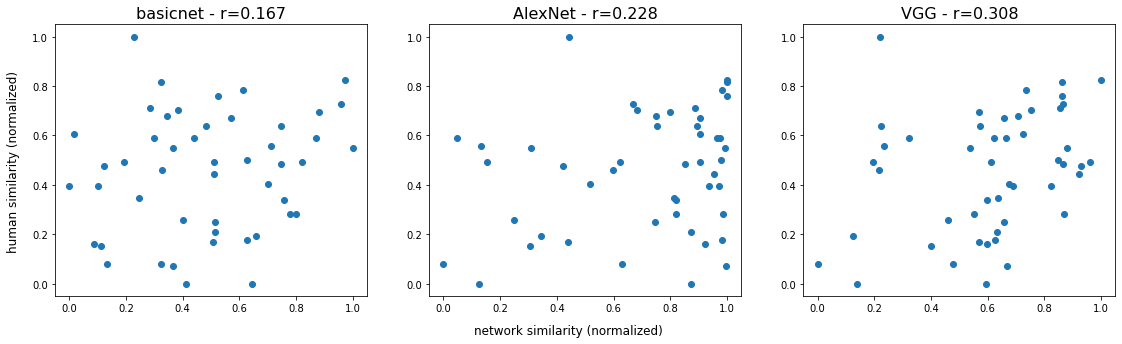

In [41]:
human_sim = [3.92, 3.38, 3.46, 3.46, 3.50, 1.50, 1.50, 4.00, 2.04, 1.96, 2.31, 3.00, 2.46, 4.15, 
 2.73, 4.15, 4.50, 4.42, 4.46, 5.88, 4.35, 3.00, 4.31, 2.12, 1.92, 3.73, 5.00, 4.73, 
 4.85, 3.31, 2.77, 5.04, 3.77, 3.46, 3.04, 2.35, 3.92, 3.92, 3.73, 1.12, 2.46, 3.23, 
 1.46, 1.12, 1.88, 3.42, 4.58, 1.85]

fig, ax = plt.subplots(1, 3, figsize=(19,5))
for i, model in enumerate(models):
    name = model.__class__.__name__
    v_sim_net_norm = normalize(similarities[name])
    v_sim_human_norm = normalize(np.array(human_sim))

    r = np.corrcoef(v_sim_net_norm,v_sim_human_norm)[0][1]

    # Scatter plot
    ax[i].set_title(f'{name} - r={round(r,3)}', fontsize=16)
    ax[i].scatter(v_sim_net_norm,v_sim_human_norm)

fig.text(0.5, 0.02, 'network similarity (normalized)', ha='center', fontsize=12)
fig.text(0.09, 0.5, 'human similarity (normalized)', va='center', rotation='vertical', fontsize=12)

In [38]:
with open(f'model_dict_style.pkl', 'rb') as f:
    model_dict_style = pickle.load(f)

Text(0.09, 0.5, 'Loss')

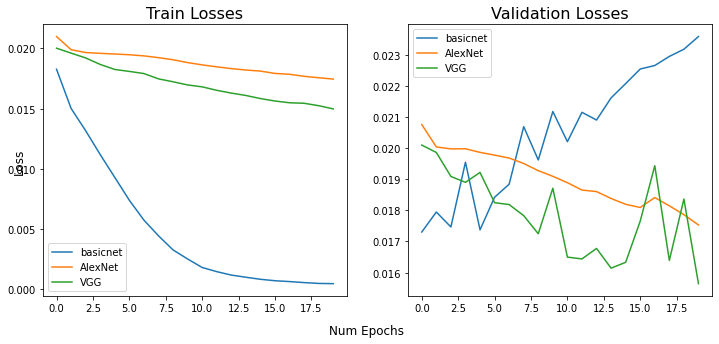

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

for i, (k, v) in enumerate(model_dict_style.items()):
    train_losses, val_losses, test_accuracy = v
    
    ax[0].plot(range(20), train_losses, label=k)
    ax[1].plot(range(20), val_losses, label=k)
    
    ax[0].set_title(f'Train Losses', fontsize=16)
    ax[1].set_title(f'Validation Losses', fontsize=16)
    
    ax[0].legend()
    ax[1].legend()
    
fig.text(0.5, 0.02, 'Num Epochs', ha='center', fontsize=12)
fig.text(0.09, 0.5, 'Loss', va='center', rotation='vertical', fontsize=12)

In [45]:
for k, v in model_dict_style.items():
    print(f'Test Accuracy for {k}: {v[2]}')

Test Accuracy for basicnet: 0.3958333333333333
Test Accuracy for AlexNet: 0.4166666666666667
Test Accuracy for VGG: 0.4895833333333333
